In [32]:
# Additional python packages
import os, urllib,cStringIO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

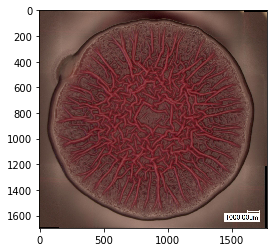

In [8]:
myurl = "https://s3.amazonaws.com/isaac-wainstein/homework/"
files = ['phz_170725_D3.jpg']
X     = np.array([])
y     = np.array([])
i     = 0

for f in files:
#     myfile  = cStringIO.StringIO(urllib.urlopen(f).read())
    img     = Image.open(f)
    img     = np.array(img)
    if i == 0:
        X = np.reshape(img, (1, -1))
    else:
        X = np.concatenate((X, np.reshape(img, (1, -1))), axis=0)
        
    if 'brewno' in f:
        y = np.append(y, 1)
    else:
        y = np.append(y, 0)

        
    imgplot = plt.imshow(img)
    plt.show()

In [47]:
img.shape

(1695, 1776, 3)

In [35]:
X = np.reshape(img, (-1, 3))

In [43]:
trace1 = go.Scatter3d(
    x=X[0,:],
    y=X[1,:],
    z=X[2,:],
    mode='markers',
    marker=dict(
        size=(np.arange(92)[::-1] * 45 / 92 + 5),
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [34]:
X, y = make_blobs(centers=4, random_state=1)
X.shape

(100, 2)

In [74]:
km = KMeans(n_clusters=7, random_state=0)
km.fit(X)
print(km.cluster_centers_.shape)
print(km.labels_.shape)
# predict is the same as labels_ on training data
# but can be applied to new data


(7, 3)
(3010320,)


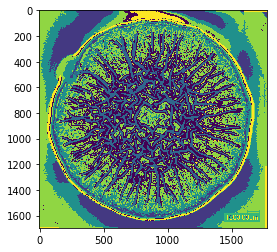

In [76]:
classes = np.reshape(km.labels_, (1695, 1776)) 
classes = np.multiply(classes, 255.0/np.max(classes)) #Nomalize
# classes = np.reshape(np.array([classes, classes, classes]), (1695, 1776, 3))
imgplot = plt.imshow(classes)
plt.show()

In [71]:
classes.shape

AttributeError: 'tuple' object has no attribute 'shape'